## Configurations for Colab

In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gym
    from pyvirtualdisplay import Display

    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 7,813 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main

# 02. Double DQN

[van Hasselt et al., "Deep Reinforcement Learning with Double Q-learning." arXiv preprint arXiv:1509.06461, 2015.](https://arxiv.org/pdf/1509.06461.pdf)




Let's take a close look at the difference between DQN and Double-DQN. The max operator in standard Q-learning and DQN uses the same values both to select and to evaluate an action. This makes it more likely to select overestimated values, resulting in overoptimistic value estimates.

$$
\theta_{t+1} = \theta_t + \alpha \big(Y_t^Q - Q(S_t, A_t; \theta_t)\big) \cdot \nabla_{\theta_t} Q(S_t, A_t; \theta_t),\\
\text{where } \alpha \text{ is a scalar step size and the target } Y_t^Q \text{is defined as }\\
Y_t^Q = R_{t+1} + \gamma \max_a Q(S_{t+1}, a; \theta_t).
$$

In Double Q-learning ([van Hasselt 2010](https://papers.nips.cc/paper/3964-double-q-learning.pdf)), two value functions are learned by assigning experiences randomly to update one of the two value functions, resulting in two sets of weights, $\theta$ and $\theta'$. For each update, one set of weights is used to determine the greedy policy and the other to determine its value. For a clear comparison, we can untangle the selection and evaluation in Q-learning and rewrite DQN's target as

$$
Y_t^Q = R_{t+1} + \gamma Q(S_{t+1}, \arg\max_a Q(S_{t+1}, a; \theta_t); \theta_t).
$$

The Double Q-learning error can then be written as

$$
Y_t^{DoubleQ} = R_{t+1} + \gamma Q(S_{t+1}, \arg\max_a Q(S_{t+1}, a; \theta_t); \theta_t').
$$

The idea of Double Q-learning is to reduce overestimations by decomposing the max operation in the target into action selection and action evaluation. Although not fully decoupled, the target network in the DQN architecture provides a natural candidate for the second value function, without having to introduce additional networks. In conclusion, the weights of the second network $\theta_t'$ are replaced with the weights of the target network for the evaluation of the current greedy policy. This makes just a small change in calculating the target value of DQN loss.

##### DQN:

```
target = reward + gamma * dqn_target(next_state).max(dim=1, keepdim=True)[0]
```

##### DoubleDQN:

```
selected_action = dqn(next_state).argmax(dim=1, keepdim=True)
target = reward + gamma * dqn_target(next_state).gather(1, selected_action)
```
      

In [ ]:
import os
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

## Replay buffer

Please see *01.dqn.ipynb* for detailed description.

In [ ]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Network

We are going to use a simple network architecture with three fully connected layers and two non-linearity functions (ReLU).

In [ ]:
class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(Network, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

## Double DQN Agent

Here is a summary of DQNAgent class.

| Method           | Note                                                 |
| ---              | ---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|compute_dqn_loss  | return dqn loss.                                     |
|update_model      | update the model by gradient descent.                |
|target_hard_update| hard update from the local model to the target model.|
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |

We use `self.dqn` instead of `self.dqn_target` for action selection.

```

        next_q_value = self.dqn_target(next_state).gather(
            1, self.dqn(next_state).argmax(dim=1, keepdim=True)  # Double DQN
        ).detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)
```

In [ ]:
class DQNAgent:
    """DQN Agent interacting with environment.

    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including
                           state, action, reward, next_state, done
    """

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        seed: int,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
    ):
        """Initialization.

        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n

        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.seed = seed
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()

        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # epsilon greedy policy
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()

        if not self.is_test:
            self.transition = [state, selected_action]

        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done = self.env.step(action)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)

        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False

        state, _ = self.env.reset(seed=self.seed)
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state, _ = self.env.reset(seed=self.seed)
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1

                # linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon, self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)

                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)

        self.env.close()

    def test(self, video_folder: str) -> None:
        """Test the agent."""
        self.is_test = True

        # for recording a video
        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)

        state, _ = self.env.reset(seed=self.seed)
        done = False
        score = 0

        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        # reset
        self.env = naive_env

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """Return dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(next_state).gather(  # Double DQN
            1, self.dqn(next_state).argmax(dim=1, keepdim=True)
        ).detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)

        # calculate dqn loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        losses: List[float],
        epsilons: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

## Environment

You can see the [code](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py) and [configurations](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py#L91) of CartPole-v1 from Farama Gymnasium's repository.

In [ ]:
# 0: normal tile
# 1: orange tile
# 2: soft switch
# 3: hard switch
# 4: goal
# 5: transport switch
# 8: block
# 9: none

# Level 1:
level_one_env = np.array(
    [
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 4, 0, 0, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    ]
)

# Level 2:
level_two_env = np.array(
    [
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 9, 9, 0, 0, 0, 9, 9, 9],
        [9, 9, 0, 0, 0, 0, 9, 9, 0, 0, 3, 0, 9, 9, 0, 4, 0, 9, 9, 9],
        [9, 9, 0, 0, 2, 0, 9, 9, 0, 0, 0, 0, 9, 9, 0, 0, 0, 9, 9, 9],
        [9, 9, 0, 0, 0, 0, 9, 9, 0, 0, 0, 0, 9, 9, 0, 0, 0, 9, 9, 9],
        [9, 9, 0, 0, 0, 0, 9, 9, 0, 0, 0, 0, 9, 9, 0, 0, 0, 9, 9, 9],
        [9, 9, 0, 0, 0, 0, 9, 9, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    ]
)

level_two_soft_switches = np.array(
    [{"switch_location": (4, 4), "toggle_tiles": [(6, 6), (6, 7)], "mode": "toggle"}]
)


level_two_hard_switches = np.array(
    [{"switch_location": (3, 10), "toggle_tiles": [(6, 12), (6, 13)]}]
)

# Level 3:
level_three_env = np.array(
    [
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9],
        [9, 9, 0, 0, 0, 0, 9, 9, 0, 0, 0, 9, 9, 0, 0, 9, 9, 9, 9, 9],
        [9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 0, 0, 9, 9, 9],
        [9, 9, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 0, 0, 4, 0, 9, 9, 9],
        [9, 9, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    ]
)

# Level 4:
level_four_env = np.array(
    [
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 1, 1, 1, 1, 1, 1, 1, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 1, 1, 1, 1, 1, 1, 1, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 0, 0, 0, 0, 9, 9, 9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9],
        [9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 0, 0, 9, 9, 9, 9, 9],
        [9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 0, 0, 9, 9, 9, 9, 9],
        [9, 9, 9, 0, 0, 0, 9, 9, 0, 0, 0, 0, 1, 1, 1, 1, 1, 9, 9, 9],
        [9, 9, 9, 0, 0, 0, 9, 9, 0, 0, 0, 0, 1, 1, 1, 1, 1, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 0, 4, 0, 9, 9, 1, 1, 0, 1, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 9, 1, 1, 1, 1, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    ]
)

# Level 5:
level_five_env = np.array(
    [
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 9, 9, 9],
        [9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 9, 9, 9],
        [9, 9, 9, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 9, 9],
        [9, 9, 9, 0, 0, 2, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 2, 9, 9, 9],
        [9, 9, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 9, 9, 9],
        [9, 9, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9],
        [9, 9, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    ]
)

level_five_soft_switches = np.array(
    [
        {
            "switch_location": (2, 10),
            "toggle_tiles": [(2, 7), (2, 8)],
            "mode": "toggle",
        },
        {
            "switch_location": (7, 16),
            "toggle_tiles": [(9, 7), (9, 8)],
            "mode": "toggle",
        },
        {"switch_location": (6, 8), "toggle_tiles": [(9, 7), (9, 8)], "mode": "off"},
        {"switch_location": (4, 5), "toggle_tiles": [(9, 7), (9, 8)], "mode": "on"},
    ]
)

# Level 6:
level_six_env = np.array(
    [
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 0, 0, 0, 0, 0, 9, 9, 9, 9],
        [9, 9, 9, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 0, 0, 0, 0, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 0, 0, 4, 0, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9, 0, 0, 0, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 0, 0, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    ]
)

# Level 7:
level_seven_env = np.array(
    [
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 9, 9, 9, 9, 9],
        [9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9, 0, 9, 9, 0, 0, 0, 0, 9, 9],
        [9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 0, 4, 0, 9, 9],
        [9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 0, 0, 3, 9, 9, 0, 0, 0, 9, 9],
        [9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 0, 0, 0, 9, 9, 0, 0, 0, 9, 9],
        [9, 9, 9, 9, 0, 0, 9, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    ]
)

level_seven_hard_switches = np.array(
    [{"switch_location": (5, 12), "toggle_tiles": [(7, 6)]}]
)


# Level 8:
level_eight_env = np.array(
    [
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9],
        [9, 9, 9, 0, 0, 0, 0, 0, 0, 9, 9, 9, 0, 0, 0, 0, 0, 0, 9, 9],
        [9, 9, 9, 0, 0, 0, 0, 5, 0, 9, 9, 9, 0, 0, 0, 0, 4, 0, 9, 9],
        [9, 9, 9, 0, 0, 0, 0, 0, 0, 9, 9, 9, 0, 0, 0, 0, 0, 0, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    ]
)

level_eight_teleport_switches = np.array(
    [{"switch_location": (6, 7), "split_positions": [(3, 13), (9, 13)]}]
)


# Level 9:
level_nine_env = np.array(
    [
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 0, 0, 0, 0, 9, 9, 9, 0, 9, 9, 9, 0, 0, 0, 0, 9, 9],
        [9, 9, 9, 0, 0, 0, 0, 9, 9, 9, 0, 9, 9, 9, 0, 0, 5, 0, 9, 9],
        [9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 4, 0, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    ]
)

level_nine_teleport_switches = np.array(
    [{"switch_location": (4, 16), "split_positions": [(4, 15), (4, 5)]}]
)


# Level 10:
level_ten_env = np.array(
    [
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 9, 9, 9],
        [9, 9, 9, 0, 4, 0, 9, 9, 0, 9, 9, 0, 0, 0, 0, 5, 0, 9, 9, 9],
        [9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9, 0, 0, 0, 0, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 9, 9, 0, 0, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 0, 2, 9, 9, 0, 0, 0, 3, 0, 9, 9, 9, 9],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    ]
)

level_ten_teleport_switches = np.array(
    [{"switch_location": (2, 15), "split_positions": [(2, 15), (2, 12)]}]
)

level_ten_hard_switches = np.array(
    [{"switch_location": (10, 14), "toggle_tiles": [(2, 9), (2, 10),(3, 15), (4, 15)]}]
)

level_ten_soft_switches = np.array(
    [{"switch_location": (10, 8), "toggle_tiles": [(2, 6), (2, 7)], "mode":"toggle"}]
)


In [ ]:
class Block:

    def __init__(self, r1, c1, r2, c2):
        self._r1 = r1
        self._r2 = r2
        self._c1 = c1
        self._c2 = c2

        self._focus_block = 0

    def set_coords(self, r1, c1, r2, c2):
        self._r1 = r1
        self._r2 = r2
        self._c1 = c1
        self._c2 = c2

    def get_coords(self):
        return self._r1, self._c1, self._r2, self._c2

    def is_upright(self):
        return self._r1 == self._r2 and self._c1 == self._c2

    def is_wide(self):
        return self._r1 == self._r2 and self._c1 != self._c2

    def move_up(self):
        match self._focus_block:
            case 0:
                # vertical
                if self.is_upright():
                    self._r1 -= 1
                    self._r2 -= 2

                # flat and wide
                elif self.is_wide():
                    self._r1 -= 1
                    self._r2 -= 1

                # flat and long
                else:
                    min_r = min(self._r1, self._r2)
                    self._r1 = min_r - 1
                    self._r2 = min_r - 1

            case 1:
                self._r1 -= 1

            case 2:
                self._r2 -= 1

    def move_down(self):
        match self._focus_block:
            case 0:
                # vertical
                if self.is_upright():
                    self._r1 += 1
                    self._r2 += 2

                # flat and wide
                elif self.is_wide():
                    self._r1 += 1
                    self._r2 += 1

                # flat and long
                else:
                    max_r = max(self._r1, self._r2)
                    self._r1 = max_r + 1
                    self._r2 = max_r + 1

            case 1:
                self._r1 += 1
            case 2:
                self._r2 += 1

    # edited
    def move_right(self):
        match self._focus_block:
            case 0:
                # vertical
                if self.is_upright():
                    self._c1 += 1
                    self._c2 += 2

                # flat and wide
                elif self.is_wide():
                    max_c = max(self._c1, self._c2)
                    self._c1 = max_c + 1
                    self._c2 = max_c + 1

                # flat and long
                else:
                    self._c1 += 1
                    self._c2 += 1

            case 1:
                self._c1 += 1
            case 2:
                self._c2 += 1

    # edited
    def move_left(self):
        match self._focus_block:
            case 0:
                # vertical
                if self.is_upright():
                    self._c1 -= 1
                    self._c2 -= 2

                # flat and wide
                elif self.is_wide():
                    min_c = min(self._c1, self._c2)
                    self._c1 = min_c - 1
                    self._c2 = min_c - 1

                # flat and long
                else:
                    self._c1 -= 1
                    self._c2 -= 1
            case 1:
                self._c1 -= 1
            case 2:
                self._c2 -= 1

    def toggle_focus(self):
        if self._focus_block == 0:
            self._focus_block = 0
        elif self._focus_block == 1:
            self._focus_block = 2
        else:
            self._focus_block = 1

    def set_focus(self, focus):
        self._focus_block = focus

    def get_focus(self):
        return self._focus_block

    def join_single_blocks(self):
        if self._focus_block == 1 or self._focus_block == 2:
            if abs(self._r1 - self._r2) == 1 and (self._c1 == self._c2):
                self.set_focus(0)
            elif abs(self._c1 - self._c2) == 1 and (self._r1 == self._r2):
                self.set_focus(0)

In [ ]:
class Level(gym.Env):
    metadata = {"render_modes": [], "render_fps": 0}

    def __init__(
        self,
        start_pos: tuple,
        base_env: np.array([]),
        soft_switches=np.array([]),
        hard_switches=np.array([]),
        teleport_switches=np.array([]),
        render_mode=None,
    ):
        self._r_start = start_pos[0]
        self._c_start = start_pos[1]

        self._block = Block(self._r_start, self._c_start, self._r_start, self._c_start)

        self._base_env = base_env

        self._soft_switches = soft_switches
        self._hard_switches = hard_switches
        self._teleport_switches = teleport_switches

        self._actions = {
            0: self._block.move_right,
            1: self._block.move_up,
            2: self._block.move_left,
            3: self._block.move_down,
            4: self._block.toggle_focus,
        }

        self.observation_space = np.append(base_env.ravel(), 0)
        self.action_space = gym.spaces.Discrete(5)

    def step(self, action):
        # if the block is split, check if single blocks are adjacent, and join together
        self._block.join_single_blocks()

        # update the agent's coords by passing it the action
        self._perform_action(action)

        # check if the agent is out of bounds -> reset to the start
        r1, c1, r2, c2 = self._block.get_coords()

        reward, done = self._is_done(r1, c1, r2, c2)

        # only check for environment changes if the action is not "Switch Focus"
        if action != 4:
            self._move_to_start(r1, c1, r2, c2)
            self._activate_teleport_switch(r1, c1, r2, c2)
            self._toggle_soft_switches(r1, c1, r2, c2)
            self._toggle_hard_switches(r1, c1, r2, c2)



        state = self._format_environment()

        return state, reward, done

    def reset(self, seed):
        # set both of the agent's coords to (self._r_start,self._c_start) and (self._r_start,self._c_start)
        self._block.set_coords(
            self._r_start, self._c_start, self._r_start, self._c_start
        )
        self._block.set_focus(0)

        # reset the environment (important to undo any obstacle interactions)
        self._current_env = np.copy(self._base_env)

        # place the agent in the environment using its position
        state = np.copy(self._current_env)
        state[self._r_start, self._c_start] = 8
        state = state.ravel()
        state = np.append(state, self._block.get_focus())
        # state = np.array2string(state, separator="") + str(self._block.get_focus())

        return state, False

    def _move_to_start(self, r1, c1, r2, c2):
        if self._current_env[r1, c1] == 9 or self._current_env[r2, c2] == 9:
            self.reset(42)

    def _is_done(self, r1, c1, r2, c2):
        # check if the agent is on the goal -> set done to True and reward to 0

        # reward is -1 and done is False unless the agent hit the goal
        reward = -1
        done = False

        if self._current_env[r1, c1] == 4 and self._current_env[r2, c2] == 4:
            reward = 0
            done = True
        # elif self._current_env[r1, c1] == 9 or self._current_env[r2, c2] == 9:
        #   reward = -1000
        #   done = True

        return reward, done

    def _format_environment(self):
        # place the agent in the environment using its position
        r1, c1, r2, c2 = self._block.get_coords()
        state = np.copy(self._current_env)
        state[r1, c1] = 8
        state[r2, c2] = 8

        state = state.ravel()
        state = np.append(state, self._block.get_focus())
        # state = np.array2string(state, separator="") + str(self._block.get_focus())

        return state

    def _toggle_soft_switches(self, r1, c1, r2, c2):
        # check if the agent is on a circle switch -> activate bridge
        for c in self._soft_switches:
            switch_location = c["switch_location"]
            toggle_tiles = c["toggle_tiles"]
            mode = c["mode"]

            if (r1 == switch_location[0] and c1 == switch_location[1]) or (
                r2 == switch_location[0] and c2 == switch_location[1]
            ):
                if mode == "toggle":
                    if self._current_env[toggle_tiles[0][0], toggle_tiles[0][1]] == 0:
                        for t in toggle_tiles:
                            self._current_env[t[0], t[1]] = 9
                            self._current_env[t[0], t[1]] = 9

                    else:
                        for t in toggle_tiles:
                            self._current_env[t[0], t[1]] = 0
                            self._current_env[t[0], t[1]] = 0
                elif mode == "on":
                    for t in toggle_tiles:
                        self._current_env[t[0], t[1]] = 0
                        self._current_env[t[0], t[1]] = 0
                elif mode == "off":
                    for t in toggle_tiles:
                        self._current_env[t[0], t[1]] = 9
                        self._current_env[t[0], t[1]] = 9

    def _toggle_hard_switches(self, r1, c1, r2, c2):
        # check if the agent is on an x switch -> activate bridge
        for c in self._hard_switches:
            switch_location = c["switch_location"]
            toggle_tiles = c["toggle_tiles"]

            if (r1 == switch_location[0] and c1 == switch_location[1]) and (
                r2 == switch_location[0] and c2 == switch_location[1]
            ):
                if self._current_env[toggle_tiles[0][0], toggle_tiles[0][1]] == 0:
                    for t in toggle_tiles:
                        self._current_env[t[0], t[1]] = 9
                        self._current_env[t[0], t[1]] = 9

                else:
                    for t in toggle_tiles:
                        self._current_env[t[0], t[1]] = 0
                        self._current_env[t[0], t[1]] = 0

    def _activate_teleport_switch(self, r1, c1, r2, c2):
        # check if block is on teleport switch -> split block into two single blocks
        for t in self._teleport_switches:
            switch_location = t["switch_location"]
            split_positions = t["split_positions"]


            if (r1 == switch_location[0] and c1 == switch_location[1]) and (
                r2 == switch_location[0] and c2 == switch_location[1]
            ):

                single_block_one = split_positions[0]
                single_block_two = split_positions[1]

                r1 = single_block_one[0]
                c1 = single_block_one[1]

                r2 = single_block_two[0]
                c2 = single_block_two[1]

                self._block.set_focus(1)
                self._block.set_coords(r1, c1, r2, c2)

    def _handle_orange_tile(self, r1, c1, r2, c2):
        # check if block is vertical
        if (r1, c1) == (r2, c2):
            # check if tile is orange tile
            if self._current_env[r1, c1] == 1:
                # tile disappears/block falls through grid

                self._block.set_coords(
                    self._r_start, self._c_start, self._r_start, self._c_start
                )

        # nothing happens if block is not vertical on an orange tile

    def _perform_action(self, action):
        # Get the corresponding method from 'actions' and call it
        action_method = self._actions.get(int(action))
        if action_method:
            action_method()

        else:
            print("Invalid action")

    def get_state(self):
        r1, c1, r2, c2 = self._block.get_coords()
        print(r1, c1, r2, c2)
        state = np.copy(self._current_env)
        state[r1, c1] = 8
        state[r2, c2] = 8

        return state

    def get_block(self):
        return self._block

In [ ]:
level = 1

if level == 1:
        env = Level(start_pos=(3, 6), base_env=level_one_env)

elif level == 2:
    env = Level(
        start_pos=(6, 3),
        base_env=level_two_env,
        soft_switches=level_two_soft_switches,
        hard_switches=level_two_hard_switches,
    )

elif level == 3:
    env = Level(start_pos=(4, 3), base_env=level_three_env)

elif level == 4:
    env = Level(start_pos=(6, 4), base_env=level_four_env)

elif level == 5:
    env = Level(
        start_pos=(2, 15),
        base_env=level_five_env,
        soft_switches=level_five_soft_switches,
    )
elif level == 6:
    env = Level(
        start_pos=(4, 3),
        base_env=level_six_env,
    )

elif level == 7:
    env = Level(
        start_pos=(4, 4),
        base_env=level_seven_env,
        hard_switches=level_seven_hard_switches,
    )

elif level == 8:
    env = Level(
        start_pos=(6, 4),
        base_env=level_eight_env,
        teleport_switches=level_eight_teleport_switches,
    )
elif level == 9:
    env = Level(
        start_pos=(4, 4),
        base_env=level_nine_env,
        teleport_switches=level_nine_teleport_switches
    )

elif level == 10:
    env = Level(
        start_pos=(2, 12),
        base_env=level_ten_env,
        soft_switches=level_ten_soft_switches,
        hard_switches=level_ten_hard_switches,
        teleport_switches=level_ten_teleport_switches,
    )

## Set random seed

In [ ]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

## Initialize

In [ ]:
# parameters
num_frames = 500000
memory_size = 1000
batch_size = 128
target_update = 100
epsilon_decay = 1 / 100

# train
agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay, seed)

cpu


## Train

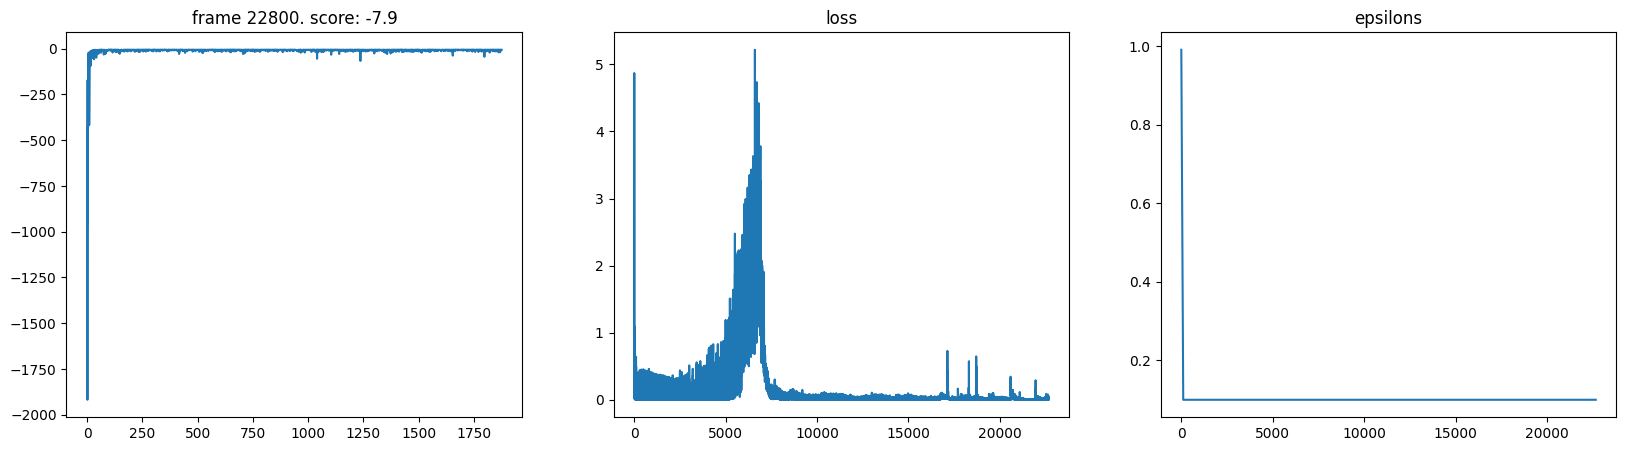

KeyboardInterrupt: 

In [ ]:
agent.train(num_frames)